In [1]:
import math
import typing as t
from pathlib import Path

import kaggle_toolbox.features.transform as feature_transforms
import numpy as np
import pandas as pd
import seaborn as sns
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from kaggle_toolbox.validation import analyze_val_strategy

sns.set_context(
    'notebook',
    font_scale=0.75,
    # rc={'figure.figsize':(4.0, 3.5)},
)

In [2]:
TARGET_LIST = [
    'cohesion',
    'syntax',
    'vocabulary',
    'phraseology',
    'grammar',
    'conventions',
]
NUM_FOLDS = 5

ROOT_DIR = Path('/kaggle')
DATA_DIR = ROOT_DIR / 'data'
FP_ELL_DATASET_DIR = DATA_DIR / 'fp-ell'
OOF_DIR = ROOT_DIR / 'oof'

TARGET_TO_LVL1_OOF_PATH_DICT = {
    'cohesion': OOF_DIR / 'cohesion-v1-layer_norm-ep_4-valfreq_0p25-pooler_att-full.csv',
    'syntax': OOF_DIR / 'syntax-v1-layer_norm-ep_3-valfreq_0p25-full.csv',
    'vocabulary': OOF_DIR / 'vocabulary-v1-layer_norm-ep_3-valfreq_0p25-std_init.csv',
    'phraseology': OOF_DIR / 'phraseology-v1-layer_norm-ep_3-valfreq_0p25-std_init-full.csv',
    'grammar': OOF_DIR / 'grammar-v1-lnorm-ep_4-valfreq_0p25-sqzr_cat_9_to_12-full.csv',
    'conventions': OOF_DIR / 'conventions-v1-layer_norm-ep_3-valfreq_0p25-full.csv',
}

In [4]:
def _load_data(
        train_csv_path: Path,
        target_to_lvl1_off_path_dict: t.Dict[str, Path],
        target_list: t.List[str]) -> pd.DataFrame:
    train_df = pd.read_csv(train_csv_path)

    target_arr = feature_transforms.contiguous_to_categorical(train_df[target_list].values)

    mskf = MultilabelStratifiedKFold(n_splits=NUM_FOLDS, shuffle=True, random_state=42)
    for fold_, (_, v_) in enumerate(mskf.split(X=train_df, y=target_arr)):
        train_df.loc[v_, 'fold'] = fold_

    print(f'Total `train_df` rows = {len(train_df)}')

    for target in target_list:
        score_df = pd.read_csv(target_to_lvl1_off_path_dict[target]).rename({'id': 'text_id'}, axis=1)
        train_df = train_df.merge(score_df, left_on='text_id', right_on='text_id')
        train_df[f'{target}_error'] = (train_df[target] - train_df[f'{target}_score']).abs()

    return train_df


score_df = _load_data(
    train_csv_path=FP_ELL_DATASET_DIR / 'train.csv',
    target_to_lvl1_off_path_dict=TARGET_TO_LVL1_OOF_PATH_DICT,
    target_list=TARGET_LIST)

analyze_val_strategy(score_df, target_list=TARGET_LIST, num_folds=NUM_FOLDS)

Total `train_df` rows = 3911


,fold,num_samples,cohesion_mean,syntax_mean,vocabulary_mean,phraseology_mean,grammar_mean,conventions_mean
0,0,782,3.077366,2.971867,3.205243,3.065857,2.959719,3.035166
1,1,783,3.125160,3.007024,3.226054,3.111111,3.015964,3.079183
2,2,782,3.140665,3.068414,3.258312,3.138747,3.069693,3.116368
3,3,782,3.131074,3.048593,3.245524,3.125959,3.042839,3.074169
4,4,782,3.161125,3.045396,3.243606,3.142583,3.076087,3.100384


In [6]:
score_df.head(3)

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,fold,cohesion_score,...,syntax_score,syntax_error,vocabulary_score,vocabulary_error,phraseology_score,phraseology_error,grammar_score,grammar_error,conventions_score,conventions_error
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,1.0,2.855740,...,2.950954,0.549046,3.219144,0.219144,3.222088,0.222088,3.093439,0.906561,2.753647,0.246353
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,0.0,2.784366,...,2.648692,0.148692,2.870578,0.129422,2.740792,0.740792,2.370473,0.370473,2.674716,0.174716
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,4.0,2.891909,...,3.007077,0.492923,3.099227,0.099227,2.975205,0.024795,2.962219,0.037781,3.016932,0.516932


In [7]:
def plot_correlations(score_df: pd.DataFrame, col_list: t.List[str]):
    feature_matrix = np.stack([score_df[col].values for col in col_list], axis=0)
    corr_matrix = np.corrcoef(feature_matrix)
    return sns.heatmap(corr_matrix, 
        xticklabels=col_list,
        yticklabels=col_list,)

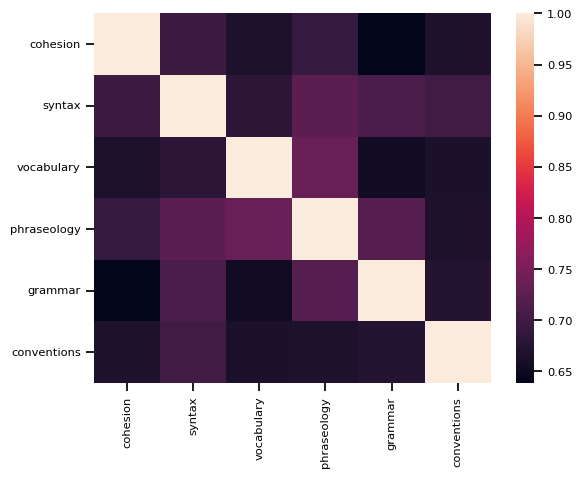

In [8]:
plot_correlations(score_df, TARGET_LIST);

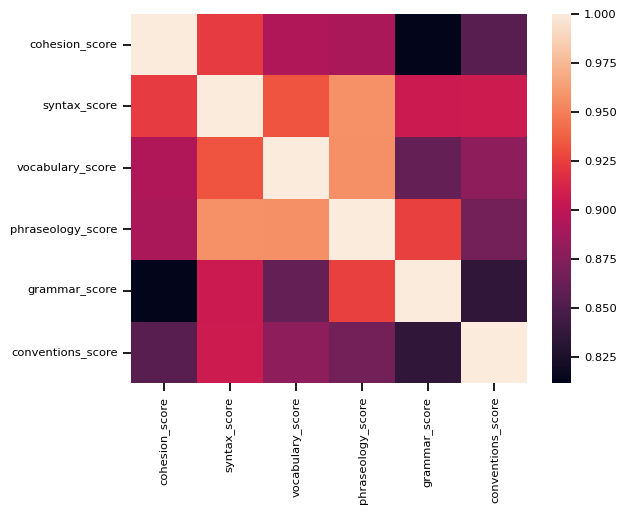

In [9]:
plot_correlations(score_df, [f'{tgt}_score' for tgt in TARGET_LIST]);

In [10]:
def compute_target_rmse(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    return math.sqrt(np.power(y_true - y_pred, 2).sum() / y_true.shape[0])

In [11]:
def compute_target_list_rmse(score_df: pd.DataFrame, target_list: t.List[str]):
    target_rmse_list = []
    for target in target_list:
        target_rmse = compute_target_rmse(score_df[target].values, score_df[f'{target}_score'].values)
        target_rmse_list.append(target_rmse)
        print(f'{target.rjust(12)} = {target_rmse:.4f}')
    print(f'{"mean".rjust(12)} = {np.array(target_rmse_list).mean():.4f}')


def compute_rmse_per_fold_and_target(score_df: pd.DataFrame, target_list: t.List, num_folds: int) -> pd.DataFrame:
    row_list = []
    for fold in range(NUM_FOLDS):
        row_list.append({'fold': fold} | {
            target: compute_target_rmse(score_df[score_df['fold'] == fold][target].values, score_df[score_df['fold'] == fold][f'{target}_score'].values)
            for target in target_list
        })
    return pd.DataFrame(row_list)

In [12]:
compute_rmse_per_fold_and_target(score_df, TARGET_LIST, NUM_FOLDS)

,fold,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0,0.473580,0.449089,0.388764,0.445892,0.453158,0.441603
1,1,0.488713,0.442728,0.415672,0.468305,0.461316,0.444779
2,2,0.485103,0.458782,0.407654,0.440526,0.469864,0.449175
3,3,0.468247,0.429764,0.418939,0.449820,0.487304,0.434095
4,4,0.474538,0.431988,0.420238,0.455845,0.471916,0.445869


In [13]:
for target in TARGET_LIST:
    num_error_lte_0p25 = len(score_df[score_df[f'{target}_error'] <= 0.25])
    num_total = len(score_df)
    print(f'{target.rjust(20)} = {num_error_lte_0p25 / num_total:.2f}')

            cohesion = 0.38
              syntax = 0.43
          vocabulary = 0.46
         phraseology = 0.42
             grammar = 0.41
         conventions = 0.42


<AxesSubplot: xlabel='cohesion_error', ylabel='Count'>

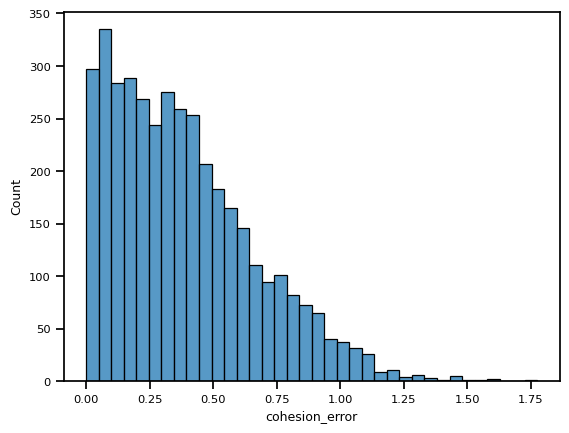

In [14]:
sns.histplot(score_df['cohesion_error'])